In [51]:
import pandas as pd
import numpy as np
import functools
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# simple conditional diffusion

Now we fit a conditional distribution on a simple distribution: $p(x|r)\sim Uni(r\cdot S_d)$, i.e, uniform distribution of a $d$-dimension circle with radius $r$.

# pretrained dataset, unit sphere, 10000 sample size

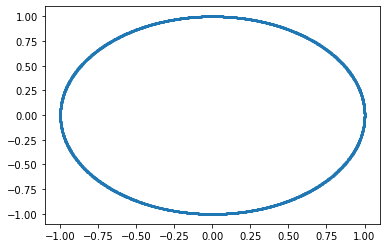

In [15]:
# read data
sample_size = 10000
X = np.random.randn(sample_size, 2) # 2 dimension data
X = X / np.linalg.norm(X,axis=1).reshape(sample_size,-1) 

X_tensor = torch.FloatTensor(X)

plt.scatter(X[:,0], X[:,1], s=1)

# demostration dataset, quater of unit sphere, 5 sample size

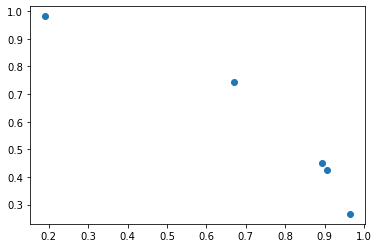

In [31]:
# read data
demo_sample_size = 5
demo_X = np.random.rand(demo_sample_size, 2) # 2 dimension data
demo_X = demo_X / np.linalg.norm(demo_X,axis=1).reshape(demo_sample_size,-1) 

demo_X_tensor = torch.FloatTensor(demo_X)
plt.scatter(demo_X[:,0], demo_X[:,1])

# Define the diffusion model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def index_iterator(device, data_len, batchsize = 32):
    perm_idx = np.random.permutation(data_len)
    num_steps = (data_len // batchsize) if (data_len % batchsize) == 0 else (data_len // batchsize) + 1
    for ii in range(num_steps):
        if ii < (num_steps - 1):
            batch_idx = perm_idx[(ii*batchsize):(ii*batchsize+batchsize)]
        else:
            batch_idx = perm_idx[(ii*batchsize):]
        
        yield batch_idx

class Diffusion_SDE(nn.Module):
    def __init__(self, input_dim, cond_dim, time_emb_dim = 32, eps=1e-5, sigma = 100, scale = 9,block_layer =1, device=None):
        super(Diffusion_SDE, self).__init__()
        self.device = device
        self.marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
        self.diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)
        self.eps = eps
        self.score_model = UNet_MLP(input_dim, cond_dim, self.marginal_prob_std_fn, time_emb_dim = time_emb_dim, scale = scale, block_layer = block_layer).to(device)
        self.input_dim = input_dim

    def forward(self, x0, cond):
        random_t = torch.rand(x0.shape[0], device=self.device) * (1. - self.eps) + self.eps 
        z = torch.randn_like(x0)
        std = self.marginal_prob_std_fn(random_t)
        perturbed_x = x0 + z * std[:, None]
        score = self.score_model(perturbed_x, cond, random_t) * std[:, None]
        loss = torch.mean(torch.sum((score  + z)**2, dim=1))
        
        return loss
    
    def em_sampler(self, cond, num_steps=1000,eps=1e-3):
        sample_size = cond.shape[0]
        t = torch.ones(sample_size, device=self.device)
        init_x = torch.randn((sample_size, self.input_dim), device=self.device) \
        * self.marginal_prob_std_fn(t)[:, None]
        time_steps = torch.linspace(1., eps, num_steps, device=device)
        step_size = time_steps[0] - time_steps[1]
        x = init_x

        with torch.no_grad():
            for time_step in time_steps:      
                batch_time_step = torch.ones(sample_size, device=device) * time_step
                g = self.diffusion_coeff_fn(batch_time_step)
                mean_x = x + (g**2)[:, None] * (self.score_model(x, cond, batch_time_step)) * step_size

                x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        return mean_x
                
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out


def marginal_prob_std(t, sigma):
    #t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return sigma**t
  

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, marginal_prob_std, time_emb_dim=32, scale = 4, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))

        
        self.marginal_prob_std = marginal_prob_std
        
        self.input_dim = input_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_dim, second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, xc, ti):
        
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)

        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out / self.marginal_prob_std(ti)[:, None]

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)

# train the diffusion model on pretrained dataset

In [18]:
diffusion_process = Diffusion_SDE(input_dim = 2, cond_dim=1, scale = 9,block_layer=2, sigma = 100, device=device)

# training 
batchsize = 128
epoch = 100
lr = 5e-4
optimizer = Adam(diffusion_process.parameters(), lr)
steps = 0
avg_loss = 0
progress = tqdm(range(epoch))
for ep in progress:
    for batch_index in index_iterator(device, len(X_tensor), batchsize = 32):
        optimizer.zero_grad()
        steps +=1 
        x0 = X_tensor[batch_index].cuda()
        xc = torch.zeros(len(batch_index),1).cuda()  ## let xc = 0, this means that for all pretrained data, we assume that the reward is 0
        loss = diffusion_process(x0, xc)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
       
    progress.set_postfix({"avg_loss":avg_loss/(steps+1)})
    if ep % 100 == 0:     
        torch.save(diffusion_process.state_dict(), "model.pkl")
        print("save model")
torch.save(diffusion_process.state_dict(), "model.pkl")
print("save model")

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<04:20,  2.63s/it, avg_loss=0.752]

save model


100%|██████████| 100/100 [04:21<00:00,  2.61s/it, avg_loss=0.393]


# sample from the pretrained diffusion model

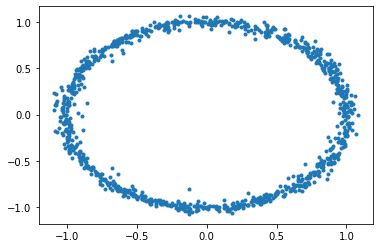

In [46]:
# sample 100 points from the diffusion process
x_gen = diffusion_process.em_sampler(torch.zeros((1000,1)).cuda()).cpu()
x_gen= x_gen

plt.plot(x_gen[:,0],x_gen[:,1],".")
plt.show()

# Baseline: supervised finetuning on demonstration data

In [44]:
baseline_diffusion_process = Diffusion_SDE(input_dim = 2, cond_dim=1, scale = 9,block_layer=2, sigma = 100, device=device)
baseline_diffusion_process.load_state_dict(torch.load("model.pkl"))

# training 
batchsize = 5
epoch = 100
lr = 5e-4
optimizer = Adam(baseline_diffusion_process.parameters(), lr)
steps = 0
avg_loss = 0
progress = tqdm(range(epoch))
for ep in progress:
    for batch_index in index_iterator(device, len(demo_X_tensor), batchsize = 32):
        optimizer.zero_grad()
        steps +=1 
        x0 = demo_X_tensor[batch_index].cuda()
        xc = torch.zeros(len(batch_index),1).cuda()  ## let xc = 0, because this input is useless for baseline
        loss = baseline_diffusion_process(x0, xc)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
       
    progress.set_postfix({"avg_loss":avg_loss/(steps+1)})
    

 11%|█         | 11/100 [00:00<00:00, 106.91it/s, avg_loss=0.237]

100%|██████████| 100/100 [00:00<00:00, 115.33it/s, avg_loss=0.245]


# sample from the SFT-finetuned model

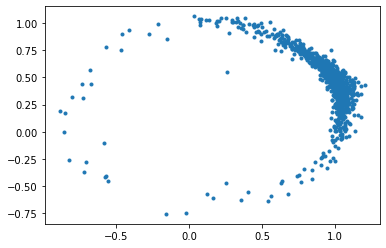

In [45]:
# sample 100 points from the diffusion process
x_gen = baseline_diffusion_process.em_sampler(torch.zeros((1000,1)).cuda()).cpu()
x_gen= x_gen

plt.plot(x_gen[:,0],x_gen[:,1],".")
plt.show()

# define the reward models

In [65]:
class Net(nn.Module):
    
    def __init__(self, dim):
        super(Net, self).__init__()
        # First fully connected layer
        self.dim = dim
        self.fc1 = nn.Linear(dim, 1024)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.fc3(out)
        out = torch.sigmoid(out)

        return out

# train the reward function

In [66]:
reward_model = Net(dim=2).cuda()

# training 
postive_batchsize = 1
batchsize = 12
steps = 50
lr = 1e-3
gamma = 0.99
optimizer = AdamW(reward_model.parameters(), lr)
avg_loss = 0
progress = tqdm(range(steps))
for step in progress:
    optimizer.zero_grad()

    postive_samples = demo_X_tensor[torch.randperm(demo_X_tensor.shape[0])[:postive_batchsize]].cuda()
    negative_samples = diffusion_process.em_sampler(torch.zeros((batchsize - postive_batchsize,1)).cuda())

    postive_scores = reward_model(postive_samples)
    negative_scores = reward_model(negative_samples)

    loss = -torch.mean(postive_scores) + gamma * torch.mean(negative_scores)

    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
       
    progress.set_postfix({"avg_loss":avg_loss/(step+1)})

    if step % 50 == 0:     
        torch.save(reward_model.state_dict(), "reward_model.pkl")
        print("save model")
torch.save(reward_model.state_dict(), "reward_model.pkl")
print("save model")

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:15,  1.55s/it, avg_loss=0.00541]

save model


100%|██████████| 50/50 [01:16<00:00,  1.53s/it, avg_loss=-.667] 

save model


# visualize the reward model

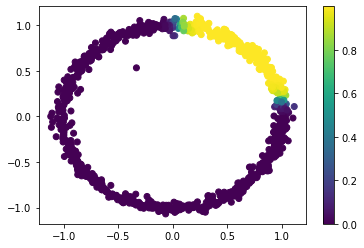

In [67]:
x_gen = diffusion_process.em_sampler(torch.zeros((1000,1)).cuda())
reward = reward_model(x_gen).cpu().detach()
x_gen = x_gen.cpu()

plt.scatter(x_gen[:,0],x_gen[:,1],c=reward)
plt.colorbar() 
plt.show()


# finetune the diffusion model with the reward function as condition

In [68]:
irl_diffusion_process = Diffusion_SDE(input_dim = 2, cond_dim=1, scale = 9,block_layer=2, sigma = 100, device=device)
data_for_finetuning = diffusion_process.em_sampler(torch.zeros((100000,1)).cuda())

In [69]:
# infer the reward
with torch.no_grad():
    reward_for_finetune_data = reward_model(data_for_finetuning)

In [71]:
reward_for_finetune_data.shap

torch.Size([100000, 1])

In [72]:
irl_diffusion_process.load_state_dict(torch.load("model.pkl"))

# training 
batchsize = 128
epoch = 10
lr = 5e-4
optimizer = Adam(irl_diffusion_process.parameters(), lr)
steps = 0
avg_loss = 0
progress = tqdm(range(epoch))
for ep in progress:
    for batch_index in index_iterator(device, len(data_for_finetuning ), batchsize = batchsize):
        optimizer.zero_grad()
        steps +=1 
        x0 = data_for_finetuning[batch_index]
        xc = reward_for_finetune_data[batch_index]  ## let xc = 0, this means that for all pretrained data, we assume that the reward is 0
        loss = irl_diffusion_process(x0, xc)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
       
    progress.set_postfix({"avg_loss":avg_loss/(steps+1)})
    if ep % 100 == 0:     
        torch.save(irl_diffusion_process.state_dict(), "irl_model.pkl")
        print("save model")
torch.save(irl_diffusion_process.state_dict(), "irl_model.pkl")
print("save model")

 10%|█         | 1/10 [00:06<00:59,  6.66s/it, avg_loss=0.287]

save model


100%|██████████| 10/10 [01:06<00:00,  6.61s/it, avg_loss=0.269]

save model


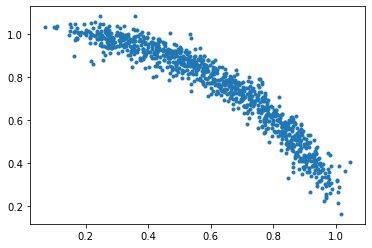

In [73]:
# sample 1000 points from the irl diffusion process
x_gen = irl_diffusion_process.em_sampler(torch.ones((1000,1)).cuda()).cpu()
x_gen= x_gen

plt.plot(x_gen[:,0],x_gen[:,1],".")
plt.show()